Equation: Allen_Cahn
Name: SS_Broyden
NC: 200000
NI: 512
NB: 512
NC_TEST: 100
SEED: 9999
EPOCHS: 5000
N_LAYERS: 3
HIDDEN: 30
FEATURES: 1
embedding_degree: 5
lr_fact: 0.2
eta: 0.01
gamma: 0.999
gamma_bfgs: 0.1
gamma_grads: 0.99
alpha: 0.999
cap_RBA: 20
max_RBA: None
vrba_potential: linear
decay_rate: 0.9
LR: 0.001
decay_step: 5000
Note: 
batch_size: 20000
k_samp: 0.0
c_samp: 1.0
phi: 1
c_log: 1.0
N_change: 100
SS_BroydenvRBA-phi:1.00-c_log:1.00-bs:20000_k:0.00_N:100.00_Seed:9999
dict_keys(['__header__', '__version__', '__globals__', 't', 'usol', 'x'])


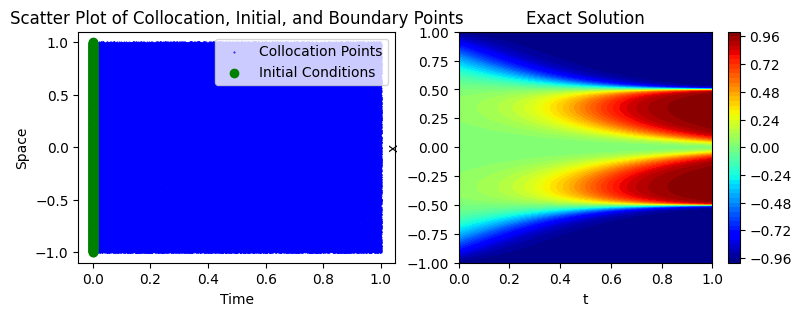

In [1]:
# ## Cell 1: Core Imports and Project Setup
import os
import sys
import time
import random
from functools import partial
from typing import Sequence, Callable 

# --- JAX, Flax, and Optax ---
import jax
import jax.numpy as jnp
from jax import Array
from jax import jit, jvp, vjp, value_and_grad, lax, vmap
from jax.flatten_util import ravel_pytree
from flax import linen as nn
import optax

# --- NumPy, SciPy, and Plotting ---
import numpy as np
import scipy
import scipy.io as sio
from scipy import sparse
from scipy.linalg import cholesky, LinAlgError
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors

# --- Other Third-Party ---
from tqdm import tqdm
from pyDOE import lhs

# --- Local Application Libraries ---
from Crunch.Models.layers import * 
from Crunch.Auxiliary.metrics import relative_l2 
from Crunch.Optimizers.minimize import minimize
from Crunch.Auxiliary.utils import static_options_SSBroyden


#from jax import config
jax.config.update("jax_enable_x64", True)
# force jax to use one device
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

# ## Cell 2: Hyperparameter Configuration (argparse)
#
import argparse
# Set up argument parser
parser = argparse.ArgumentParser(description='Tuning Parameters')
parser.add_argument('--Equation', type=str, default='Allen_Cahn', help='Name of equation')
parser.add_argument('--Name', type=str, default='SS_Broyden', help='Name of the experiment')
parser.add_argument('--NC', type=int, default=200000, help='Number of samples for training')
parser.add_argument('--NI', type=int, default=512, help='Number of iterations')
parser.add_argument('--NB', type=int, default=512, help='Batch size')
parser.add_argument('--NC_TEST', type=int, default=100, help='Number of test samples')
parser.add_argument('--SEED', type=int, default=9999, help='Random seed')
parser.add_argument('--EPOCHS', type=int, default=5000, help='Number of training epochs')
parser.add_argument('--N_LAYERS', type=int, default=3, help='Number of layers in the network')
parser.add_argument('--HIDDEN', type=int, default=30, help='Number of hidden units per layer')
parser.add_argument('--FEATURES', type=int, default=1, help='Feature size')
parser.add_argument('--embedding_degree', type=int, default=5, help='Degree of features')
parser.add_argument('--lr_fact', type=float, default=0.2, help='Scale Lr')
parser.add_argument('--eta', type=float, default=0.01, help='Learning rate or step size for adaptive gamma')
parser.add_argument('--gamma', type=float, default=0.999, help='Decay rate for adaptive gamma')
parser.add_argument('--gamma_bfgs', type=float, default=0.1, help='Decay rate for adaptive gamma')
parser.add_argument('--gamma_grads', type=float, default=0.99, help='Decay rate for adaptive gamma')
parser.add_argument('--alpha', type=float, default=0.999, help='Decay rate for exponential moving average')
parser.add_argument('--cap_RBA', type=float, default=20, help='Cap limit for RBA')
parser.add_argument('--max_RBA', type=float, help='Maximum RBA value, default calculated as eta / (1 - gamma)')
parser.add_argument('--vrba_potential', type=str, default='exponential', help='In case')
parser.add_argument('--decay_rate', type=float, default=0.9, help='Decay rate for learning rate schedule')
parser.add_argument('--LR', type=float, default=1e-3, help='Initial learning rate')
parser.add_argument('--decay_step', type=int,default=5000, help='Decay step size')
parser.add_argument('--Note', type=str, default='', help='In case')
parser.add_argument('--batch_size', type=int, default=20000, help='batch_size')
parser.add_argument('--k_samp', type=float, default=1.0, help='Enhance outliers smoothing factor')
parser.add_argument('--c_samp', type=float, default=0.0, help='homogenize')
parser.add_argument('--phi', type=float, default=1, help='Enhance outliers smoothing factor')
parser.add_argument('--c_log', type=float, default=1.0, help='homogenize')
parser.add_argument('--N_change', type=int, default=100, help='homogenize')
# Parse arguments and display them
args, unknown = parser.parse_known_args()
for arg, value in vars(args).items():
    print(f'{arg}: {value}')
# Data
NC = args.NC
NI = args.NI
NB = args.NB
NC_TEST = args.NC_TEST
#Representation Model
#- Input transfromations
embedding_degree = args.embedding_degree
# - Architecture
N_LAYERS = args.N_LAYERS # Number of Layers
HIDDEN = args.HIDDEN #hidden neurons per layer
FEATURES = args.FEATURES # Number of output fetures
# - 1st Stage Optmization
## Adam
EPOCHS = args.EPOCHS
eta = args.eta
decay_rate = args.decay_rate
LR = args.LR
lr0 = LR
decay_step = args.decay_step
## vRBA Params
gamma = args.gamma
alpha = args.alpha
c_log=args.c_log
phi=args.phi
##  We use a self scaling algoirhtm to automatically tune the global weights and to increase the cap of RBA to improve learning dunamics
max_RBA0 = args.max_RBA if args.max_RBA is not None else eta / (1 - gamma)
cap_RBA = args.cap_RBA
gamma_grads=args.gamma_grads
## vRBA Params Second order_ Sampling + SSBroycen
k_samp_bfgs = args.k_samp
c_samp_bfgs = args.c_samp
Nchange = args.N_change  # Number of SSBroyden steps before resampling
batch_size=args.batch_size
Nbfgs=80000 # Number of SSBroyden BFGs iterations
# random key
SEED = args.SEED
key = jax.random.PRNGKey(SEED)
key, subkey = jax.random.split(key, 2)
# Initialize NumPy seed
np.random.seed(SEED)
# Name of the project
args.Name=args.Name+f'vRBA-phi:{phi:.2f}-c_log:{c_log:.2f}-bs:{batch_size}_k:{k_samp_bfgs:.2f}_N:{Nchange:.2f}_Seed:{SEED}'+args.Note
print(args.Name)
#Define folder
file_path = os.getcwd()
project_root = os.path.dirname(os.path.dirname(file_path))
args.Name =project_root+'/Results/'+args.Equation+'/'+args.Name+'/'
os.makedirs(args.Name, exist_ok=True)

# ## Cell 3: Data Loading and Ground Truth Definition


available_data_sets_path='/users/jdtoscan/data/jdtoscan/References/Variational-Residual-Based-Attention-vRBA-for-PINNs-and-Operator-Networks-/PINN/Data/allen_cahn_HR.mat'
data = scipy.io.loadmat(available_data_sets_path)
print(data.keys())
Exact = data['usol'].T
Exact0 = np.real(Exact).astype(jnp.float64)  
t0 = data['t'].flatten()[:,None].astype(jnp.float64)     
x0 = data['x'].flatten()[:,None].astype(jnp.float64)    
T, X = np.meshgrid(t0, x0)
# Ground Truth (to compute relative errors)
t = T.flatten()[:,None]
x = X.flatten()[:,None]
u_gt = Exact0.flatten()[:,None]

# ## Cell 4: Data Processing, Sampling, and Visualization
# Collocation points
lb_D = jnp.array([t0.min(), x0.min()])
ub_D = jnp.array([t0.max(), x0.max()])
# Generate collocation points and ensure they are float64
X_c = lb_D + (ub_D - lb_D) * lhs(2, NC)
X_c = X_c.astype(jnp.float64)
tc = X_c[:, 0:1]
xc = X_c[:, 1:2]
# Initial conditions
ti = T[:, 0:1]
xi = X[:, 0:1]
ui = xi**2 * jnp.cos(jnp.pi * xi)
# Boundary Conditions (not used in the 2nd order part, but good practice)
keys = jax.random.split(key, 13)
tb = jax.random.uniform(keys[3], (NB, 1), minval=lb_D[0], maxval=ub_D[0]).astype(jnp.float64)
# This data tuple is now consistently float64
train_data = tc, xc, ti, xi, ui
lambdas = tc * 0 + 0.1
# Plotting code
fig = plt.figure(figsize=(9, 3))
# Scatter plot for collocation, initial, and boundary points
ax1 = fig.add_subplot(121)
ax1.scatter(tc, xc, color='blue', label='Collocation Points',s=0.2)
ax1.scatter(ti, xi, color='green', label='Initial Conditions')
ax1.set_xlabel('Time')
ax1.set_ylabel('Space')
ax1.set_title('Scatter Plot of Collocation, Initial, and Boundary Points')
ax1.legend()
# Surface plot for Exact solution
ax2 = fig.add_subplot(122)
contour = ax2.contourf(T, X, Exact0, cmap='jet', levels=50)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax2.set_xlabel('t')
ax2.set_ylabel('x')
ax2.set_title('Exact Solution')
plt.savefig('Boundaries_data.png',dpi=300)
plt.show()


# Generate SNR Batches
# Create a separate set of data to estimate SNR cleanly
n_batches_snr = 100
NC_SNR = batch_size * n_batches_snr
X_snr = lb_D + (ub_D - lb_D) * lhs(2, NC_SNR)
X_snr = X_snr.astype(jnp.float64)
# Create batches (Split array)
X_batches_snr = jnp.array_split(X_snr, n_batches_snr)

In [2]:
# ## Cell 5: Model Architecture Definition (The PINN Structure)
class Periodic_Fourier_Features(nn.Module):
    kmax: int = 1
    Lx: float = 2.0
    @nn.compact
    def __call__(self, X: Array) -> Array:
        ks = jnp.arange(1, self.kmax + 1)
        Xper = 2 * jnp.pi * jnp.matmul(X, ks[None, :]) / self.Lx
        xcos = jnp.cos(Xper)
        xsin = jnp.sin(Xper)
        Xper = jnp.concatenate([xcos, xsin], axis=1)
        return Xper
class MLP(nn.Module):
    features: Sequence[int]
    activation: Callable = nn.tanh
    @nn.compact
    def __call__(self, Z: Array) -> Array:
        init = nn.initializers.glorot_normal()
        for fs in self.features[:-1]:
            Z = nn.Dense(fs, kernel_init=init)(Z)
            # Use the activation function from the attribute
            Z = self.activation(Z)
        Z = nn.Dense(self.features[-1], kernel_init=init)(Z)
        return Z
class PINN(nn.Module):
    features: Sequence[int]
    embedding_degree: int = 1
    Lx: float = 2.0
    activation: Callable = nn.tanh
    def setup(self):
         self.enbedding = Periodic_Fourier_Features(kmax=self.embedding_degree, Lx=self.Lx)
         self.MLP = MLP(features=self.features, activation=self.activation)
    @nn.compact
    @nn.compact
    def __call__(self, t: Array, x: Array) -> Array:
        t_normalized = t 
        x_embedded = self.enbedding(x)
        X_concat = jnp.concatenate([t_normalized, x_embedded], axis=-1)
        H = self.MLP(X_concat)
        return H

# ## Cell 6: Model and Optimizer Initialization


feat_sizes = tuple([HIDDEN for _ in range(N_LAYERS)] + [FEATURES])
print(feat_sizes)
# make & init model
model = PINN(feat_sizes,activation=nn.tanh,embedding_degree=embedding_degree)
params = model.init(subkey, jnp.ones((NC, 1), dtype=jnp.float64), jnp.ones((NC, 1), dtype=jnp.float64))
params = jax.tree_util.tree_map(lambda x: x.astype(jnp.float64), params)
optimizers = {}
for key_params in params['params'].keys():
    if key_params=='g_fx':
        optimizers[key_params]=optax.adam(optax.exponential_decay(lr0*args.lr_fact, decay_step, decay_rate, staircase=False))
    else:
        optimizers[key_params]=optax.adam(optax.exponential_decay(lr0, decay_step, decay_rate, staircase=False))
# Initialize optimizer states for each parameter group
states = {key_params: optim.init(params['params'][key_params]) for key_params, optim in optimizers.items()}
# forward & loss function
apply_fn = jax.jit(model.apply)
total_params = sum(x.size for x in jax.tree_util.tree_leaves(params))
print(total_params )

# ## Cell 7: PDE Residual Definition
def Allen_Cahn(params, t, x, apply_fn, epsilon):
    u = apply_fn(params, t, x)
    v_t = jnp.ones_like(t)
    v_x = jnp.ones_like(x)
    ut = jvp(lambda t_val: apply_fn(params, t_val, x), (t,), (v_t,))[1]
    uxx = hvp_fwdfwd(lambda x_val: apply_fn(params, t, x_val), (x,), (v_x,))
    return ut - epsilon * uxx + 5.0 * u ** 3 - 5.0 * u
PDE_residuals=Allen_Cahn

# ## Cell 9: vRBA Steps 1 & 3 - Weight & Multiplier Generation
@partial(jit, static_argnums=(2, 3))
def get_exact_epsilon(values, r_max, potential_type, n_newton=5):
    """
    Solves for the exact epsilon in FLOAT64.
    Safety clamps relaxed to 1e-16 to allow for sharper distributions.
    """
    N = values.shape[0]
    
    # SAFETY: Prevent 0.0 guess. 
    # Float64 allows us to go down to ~1e-16 safely.
    r_max_safe = jnp.maximum(r_max, 1e-16)
    
    # 1. Initialization (Asymptotic Approximations)
    if potential_type == 'cosh':
        # Constraint: mean(sinh(r/eps)) = 1
        eps_guess = r_max_safe / (jnp.log(2.0 * N) + 1e-16)
        
    elif potential_type == 'superexp':
        # Constraint: mean( u * exp(u^2) ) = 1
        eps_guess = r_max_safe / jnp.sqrt(jnp.log(N) + 1e-16)
    else:
        return 1.0

    # 2. Newton Step Definition
    def newton_step(i, eps):
        # We can allow eps to be much smaller now
        eps_safe = jnp.maximum(eps, 1e-20)
        u = values / eps_safe
        
        if potential_type == 'cosh':
            # Target: mean(sinh(u)) - 1 = 0
            s_val = jnp.sinh(u)
            c_val = jnp.cosh(u)
            val = jnp.mean(s_val) - 1.0
            grad = jnp.mean(c_val * (-u / eps_safe))
            
        elif potential_type == 'superexp':
            # Target: mean(u * exp(u^2)) - 1 = 0
            exp_u2 = jnp.exp(u**2)
            term = u * exp_u2
            val = jnp.mean(term) - 1.0
            grad = jnp.mean(-(1.0 / eps_safe) * term * (1.0 + 2.0 * u**2))
        
        else:
             val = 0.0
             grad = 1.0
            
        return eps - val / (grad - 1e-20) # Tighter gradient clamp

    # 3. Run Solver
    epsilon_final = lax.fori_loop(0, n_newton, newton_step, eps_guess)
    
    # Final Output Clamp:
    # In float64, we can return epsilons as small as 1e-16 without 
    # causing immediate overflow in the subsequent weight calculation.
    return jnp.maximum(epsilon_final, 1e-16)


# ## Cell 9: vRBA Steps 1 & 3 - Weight & Multiplier Generation

def update_vRBA(
    r_i_norm, lambdas_batch, it,
    c_log=1.0, gamma=0.999, eta=0.01, phi=1.0,
    potential_type='exponential', p_val=4.0):
    
    # Ensure inputs are treated as magnitudes
    r_val = jnp.abs(r_i_norm)
    r_max = jnp.max(r_val)

    # 2. Compute Unnormalized Weights (q_it) based on specific potential logic
    if potential_type == 'exponential':
        # Rule: Logarithmic Annealing
        epsilon_q = c_log * r_max / jnp.log(it + 2.0)
        beta_it = 1.0 / (epsilon_q + 1e-16)
        q_it = beta_it * jnp.exp(beta_it * r_val)

    elif potential_type == 'cosh':
        # Rule: Exact Solver (Hybrid)
        epsilon_q = get_exact_epsilon(r_val, r_max, 'cosh', n_newton=5)
        beta_it = 1.0 / (epsilon_q + 1e-16)
        q_it = jnp.sinh(beta_it * r_val)

    elif potential_type == 'superexp':
        # Rule: Exact Solver (Hard Constraints)
        epsilon_q = get_exact_epsilon(r_val, r_max, 'superexp', n_newton=5)
        beta_it = 1.0 / (epsilon_q + 1e-16)
        u = beta_it * r_val
        q_it = u * jnp.exp(u**2)

    elif potential_type == 'logarithmic':
        # Rule: Mean Scaling (Robust)
        epsilon_q = jnp.mean(r_val) / (jnp.e - 1.0)
        beta_it = 1.0 / (epsilon_q + 1e-16)
        q_it = jnp.log(beta_it * r_val + 1.0)

    elif potential_type == 'lp':
        # Generic Lp: q ~ r^(p-1)
        q_it = jnp.power(r_val, p_val - 1.0)
        
    elif potential_type == 'quadratic':
        # Variance Minimization: q ~ r
        q_it = r_val


    elif potential_type == 'linear':
        # No Adaptation: q ~ 1
        q_it = jnp.ones_like(r_val)
        return q_it
        
    else:
        # Default fallback
        print('ERROR NOT DEFINED')

    q_norm = q_it / (jnp.max(q_it) + 1e-20)
    lambda_it = phi * q_norm + (1.0 - phi)
    
    # 4. Update (EMA)
    new_lambdas = gamma * lambdas_batch + eta * lambda_it
    return new_lambdas

# Configuration extraction
METHOD = args.vrba_potential 
c_log = args.c_log
phi = args.phi

# Create the JIT-compiled update function with static hyperparameters
update_fn_with_baked_in_type = partial(
    update_vRBA,
    c_log=c_log,
    phi=phi,
    potential_type=METHOD,
    p_val=4.0 
)

update_weights_fn = jax.jit(update_fn_with_baked_in_type)


# ## Cell 10: Optax Model Update Step


@partial(jax.jit, static_argnums=(0, 1))  # key and optimizer are static
def update_model(key_params, optimizer, gradient, params, state):
    updates, new_state = optimizer.update(gradient['params'][key_params], state)
    new_params = optax.apply_updates(params['params'][key_params], updates)
    params['params'][key_params] = new_params
    return params, new_state

# ## Cell 11: Main Training Step (Adam) & Gradient Calculation
@partial(jax.jit, static_argnums=(0, 1))
def apply_model(
    apply_fn,
    update_weights_fn,
    params, lambdas, lamB,
    all_grads,
    idx_train, it,
    hyperparams,
    epsilon,
    *train_data
):
    lamE,gamma, eta, gamma_grads, alpha = hyperparams
    t, x, ti, xi, ui = train_data
    lambdas_it = lambdas[idx_train]
    def loss_pde(params, lambdas):
        residuals = PDE_residuals(params, t, x, apply_fn, epsilon)
        r_i_norm = lax.stop_gradient(jnp.abs(residuals))
        new_lambdas = update_weights_fn(r_i_norm, lambdas, it,
                                          gamma=gamma,
                                          eta=eta)
        pde_loss = jnp.mean((new_lambdas * residuals) ** 2)
        return pde_loss, (new_lambdas, residuals)

    def loss_bcs(params):
        u_pred = apply_fn(params, ti, xi)
        ics_loss = jnp.mean((ui - u_pred) ** 2)
        return ics_loss

    (pde_loss, (new_lambdas, pde_residuals)), gradient_pde = jax.value_and_grad(loss_pde, has_aux=True)(params, lambdas_it)
    ics_loss, gradient_bcs = jax.value_and_grad(loss_bcs)(params)
    lambdas = lambdas.at[idx_train].set(new_lambdas)
    pde_gradient_flat, _ = ravel_pytree(gradient_pde)
    bcs_gradient_flat, _ = ravel_pytree(gradient_bcs)
    grad_PDE_norm = jnp.linalg.norm(pde_gradient_flat) + 1e-20
    grad_bcs_norm = jnp.linalg.norm(bcs_gradient_flat) + 1e-20
    # This line now correctly uses the 'all_grads' that was passed in
    grad_avg_PDE = gamma_grads * all_grads['grad_bar_PDE'] + (1.0 - gamma_grads) * grad_PDE_norm
    grad_avg_BCs = gamma_grads * all_grads['grad_bar_BCs'] + (1.0 - gamma_grads) * grad_bcs_norm
    lamB = alpha * lamB + (1.0 - alpha) * grad_avg_PDE / (grad_avg_BCs + 1e-20)
    total_gradient = jax.tree_util.tree_map(lambda g_pde, g_bcs: lamE * g_pde + lamB * g_bcs, gradient_pde, gradient_bcs)
    all_loss = {
        'loss_PDE': pde_loss,
        'loss_BCs': ics_loss,
        'Loss': lamE * pde_loss + lamB * ics_loss,
    }
    all_grads_updated = {
        'grad_bar_PDE': grad_avg_PDE,
        'grad_bar_BCs': grad_avg_BCs,
    }
    return all_loss, total_gradient, lambdas, lamB, all_grads_updated, pde_residuals
#
@partial(jax.jit, static_argnums=(0, 1))
def get_gradients(
    apply_fn,
    update_weights_fn,
    params, lambdas, lamB,
    it,
    hyperparams,
    epsilon,
    *train_data
):
    lamE, gamma, eta, gamma_grads, alpha = hyperparams
    t, x, ti, xi, ui = train_data
    
    def loss_pde(params, lambdas):
        residuals = PDE_residuals(params, t, x, apply_fn, epsilon)
        pde_loss = jnp.mean((residuals) ** 2)
        return pde_loss, lambdas

    def loss_bcs(params):
        u_pred = apply_fn(params, ti, xi)
        ics_loss = jnp.mean((ui - u_pred) ** 2)
        return ics_loss
    # Compute gradients
    (pde_loss, new_lambdas), gradient_pde = jax.value_and_grad(loss_pde, has_aux=True)(params, lambdas)
    ics_loss, gradient_bcs = jax.value_and_grad(loss_bcs)(params)
    # Combine gradients (Total Loss Gradient)
    total_gradient = jax.tree_util.tree_map(lambda g_pde, g_bcs: lamE * g_pde + lamB * g_bcs, gradient_pde, gradient_bcs)
    # Flatten
    grads_flat, _ = ravel_pytree(total_gradient)
    grads_norm = jnp.linalg.norm(grads_flat) + 1e-20
    return grads_flat/grads_norm

def get_SRN(apply_fn, update_weights_fn, params, lambdas, lamB, it, hyperparams, epsilon, X_batches, ti, xi, ui):    
    all_gradients = []
    
    # Iterate over batches to collect gradients
    for X_batch in X_batches:

        tc_b = X_batch[:, 0:1]
        xc_b = X_batch[:, 1:2]
        train_data_batch = (tc_b, xc_b, ti, xi, ui)
            
        # Get Gradient
        grad_flat = get_gradients(
            apply_fn, update_weights_fn, params, lambdas, lamB, 
            it, hyperparams, epsilon, *train_data_batch
        )
        all_gradients.append(grad_flat)

    # Compute Statistics
    all_gradients = jnp.stack(all_gradients) 
    mean_grad = jnp.mean(all_gradients, axis=0)
    std_grad = jnp.std(all_gradients, axis=0)
    
    norm_mean_grad = jnp.linalg.norm(mean_grad)
    norm_std_grad = jnp.linalg.norm(std_grad)
    
    snr = norm_mean_grad / (norm_std_grad + 1e-16)
    return snr

# ## Cell 12: vRBA Implementation via Importance Sampling
# 


@partial(jax.jit, static_argnames=("batch_size", "k", "c"))
def sample_points_pdf(key, batch_size, lambdas, tc, xc, ti, xi, ui, k=1, c=0.5):
    # Adjust lambdas with exponent k and normalize
    lambdas_k = lambdas**k
    lambdas_k = lambdas_k / (lambdas_k.mean() + 1e-20) + c # Added epsilon
    lambdas_k = lambdas_k.flatten()
    p = lambdas_k / (lambdas_k.sum() + 1e-20) # Added epsilon
    idx_train = jax.random.choice(
        key, len(lambdas), shape=(batch_size,), p=p
    )
    train_data = (tc[idx_train], xc[idx_train], ti, xi, ui)
    return idx_train, train_data


(30, 30, 30, 1)
2251


In [3]:
# ## Cell 13: Main Adam Training Loop
def get_gamma(eta, max_RBA):
    gamma_it = 1-eta/max_RBA
    return gamma_it
all_errors = []
all_L_infty = []
all_L_2 = []
all_its = []
all_loss = []
all_gamma = []
all_lamB = []
all_max_RBA = []
all_lambdas=[]
all_idx=[]
all_SNR = []
all_var_res = []
all_linf_res = []
epsilon = 1e-4
start = time.time()
pbar = tqdm(range(1, EPOCHS + 1), desc='Training Progress')
gamma_it=get_gamma(eta, max_RBA0)
#Global weights
max_RBA=max_RBA0
lamE,lamB=1,max_RBA**2
#RBA
step_RBA=(cap_RBA-max_RBA0)/(EPOCHS/50000-1)
# initialize grads container
all_grads={
    'grad_bar_PDE':1,
    'grad_bar_BCs':1,
}
for e in pbar:
    key, subkey = jax.random.split(key)
    idx_train, train_data = sample_points_pdf(
        subkey, batch_size, lambdas, tc, xc, ti, xi, ui, k=args.k_samp, c=args.c_samp
    )
    # single run
    hyperparams = (lamE, gamma_it, eta, gamma_grads, alpha)
    all_loss_it, gradient, lambdas, lamB, all_grads, pde_residuals = apply_model(
        apply_fn, update_weights_fn,
        params, lambdas,
        lamB,
        all_grads,
        idx_train,
        e,
        hyperparams,
        epsilon,
        *train_data
    )
    for key_params in params['params']:
        params, states[key_params] = update_model(key_params, optimizers[key_params], gradient, params, states[key_params])
    log_frequency = 1 if e < 500 else 100 if e <= 5000 else 500
    if e % log_frequency == 0:
        # Update RBA
        max_RBA = max_RBA0 + step_RBA * e // 50000
        gamma_it = get_gamma(eta, max_RBA)
        all_lambdas.append(np.array(lambdas))
        all_idx.append(idx_train)
        # Compute SNR
        current_snr = get_SRN(
            apply_fn, update_weights_fn, params, lambdas, lamB, 
            e, hyperparams, epsilon, X_batches_snr, ti, xi, ui
        )
        # Compute errors
        u_pred_it = apply_fn(params, t, x)
        error = relative_l2(u_pred_it, u_gt)
        error_vec = u_pred_it - u_gt
        L_infty = scipy.linalg.norm(error_vec.flatten(), ord=np.inf)
        L_2 = scipy.linalg.norm(error_vec.flatten(), ord=2)

        # Calculate and store residual metrics
        var_res = jnp.var(pde_residuals)
        linf_res = jnp.max(jnp.abs(pde_residuals))
        all_var_res.append(var_res)
        all_linf_res.append(linf_res)

        # Updating the tqdm progress bar with loss and other metrics
        pbar.set_description(f"It: {e}/{EPOCHS} | Epsilon: {epsilon:.1e} | Error: {error:.3e} | lam_max: {lambdas.max():.3f}| max_RBA: {max_RBA:.3f}| lamB: {lamB:.3f}|")
        all_errors.append(error)
        all_its.append(e)
        all_lambdas.append(np.array(lambdas))
        all_loss.append(all_loss_it['Loss'])
        all_gamma.append(gamma_it)
        all_lamB.append(lamB)
        all_max_RBA.append(max_RBA)
        all_SNR.append(current_snr)

        # Error norms
        all_L_infty.append(L_infty)
        all_L_2.append(L_2)
end = time.time()
print(f'Runtime: {((end - start) / EPOCHS * 1000):.2f} ms/iter.')



It: 5000/5000 | Epsilon: 1.0e-04 | Error: 5.424e-01 | lam_max: 1.000| max_RBA: 8.000| lamB: 74.302|: 100%|██████████| 5000/5000 [01:43<00:00, 48.32it/s] 

Runtime: 20.70 ms/iter.


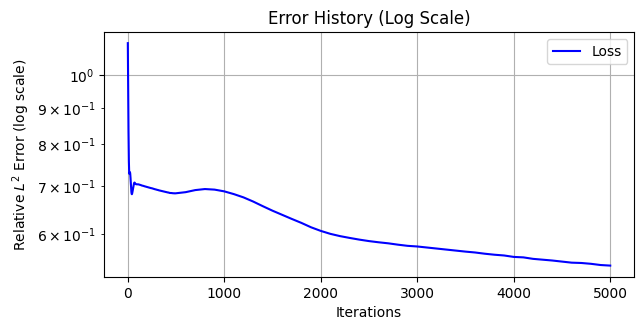

RL2 error: 0.54238755
Solution:


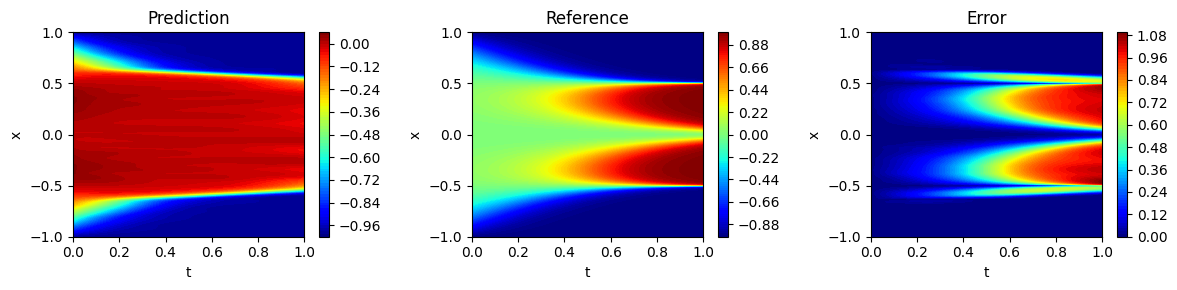

RL2 error: 0.54238755
Reconstructed parameters: RL2 error: 0.54238755


In [4]:

# ## Cell 14: Visualization & Evaluation (Adam Phase)
# 

# Adjusting the plot to use a log scale for both loss and error
plt.figure(figsize=(12, 6))
# Plotting loss history with log scale
plt.subplot(2, 2, 1)
plt.plot(all_its, all_errors, label='Loss', color='blue')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Relative $L^2$ Error (log scale)')
plt.title('Error History (Log Scale)')
plt.grid(True)
plt.legend()

# Show the plots
plt.tight_layout()
plt.savefig('Loss_Adam.png')
plt.show()



error = relative_l2(apply_fn(params, t, x), u_gt)
print(f'RL2 error: {error:.8f}') 


it=-1
print('Solution:')
u = apply_fn(params, t, x)
u = u.reshape(T.shape)
lambdas_grid=all_lambdas[it]
idx_it=all_idx[it]

# Plotting code
fig = plt.figure(figsize=(12, 3))
levels=100
# Scatter plot for collocation, initial, and boundary points
ax1 = fig.add_subplot(131)
contour = ax1.contourf(T, X, u, cmap='jet', levels=levels)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax1.set_xlabel('t')
ax1.set_ylabel('x')
ax1.set_title('Prediction')

# Surface plot for Exact solution
ax2 = fig.add_subplot(132)
contour = ax2.contourf(T, X, Exact0, cmap='jet', levels=levels)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax2.set_xlabel('t')
ax2.set_ylabel('x')
ax2.set_title('Reference')
# Surface plot for Exact solution
ax3 = fig.add_subplot(133)
contour = ax3.contourf(T, X, np.abs(Exact0-u), cmap='jet', levels=levels)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax3.set_xlabel('t')
ax3.set_ylabel('x')
ax3.set_title('Error')
plt.tight_layout()

plt.savefig('Errorss_Adam.png',dpi=300)
plt.show()
#

# ## Cell 15: Preparation for Second-Order Optimization (SSBroyden)
gamma = args.gamma_bfgs
eta = 1-gamma
initial_weights, unflatten_func = ravel_pytree(params)
params_test=unflatten_func(initial_weights)
error = relative_l2(apply_fn(params, t, x), u_gt)
print(f'RL2 error: {error:.8f}') 
error = relative_l2(apply_fn(params_test, t, x), u_gt)
print(f'Reconstructed parameters: RL2 error: {error:.8f}') 
X=np.hstack([tc.astype(jnp.float64),xc.astype(jnp.float64)])
#

# ## Cell 16: Defining the Loss Functions for Second-Order Optimization
@partial(jax.jit, static_argnums=(0,))
def apply_model_2nd_Order(apply_fn, params, epsilon, lamB, *train_data):
    t, x, ti, xi, ui = train_data
    def loss_pde(params):
        # Compute residuals
        residuals = PDE_residuals(params, t, x, apply_fn, epsilon)
        pde_loss = jnp.mean((residuals)**2)
        return pde_loss
    def loss_bcs(params):
        # Compute initial condition loss
        u_pred = apply_fn(params, ti, xi)
        ics_loss = jnp.mean((ui - u_pred) ** 2)
        return ics_loss
    def loss(params):
        return loss_pde(params) + lamB * loss_bcs(params)
    loss_value=loss(params)
    return loss_value
@partial(jax.jit, static_argnums=(1, 2))
def loss_and_gradient(weights, N_arg, unflatten_func_arg, epsilon, lamB, *train_data_tuple_arg):
    flat_jax_array = weights
    params_current = unflatten_func_arg(flat_jax_array)
    loss_val_jax = apply_model_2nd_Order(N_arg, params_current, epsilon, lamB, *train_data_tuple_arg)
    return loss_val_jax
#

# ## Cell 17: The SSBroyden Optimization Step Function
def update_lambdas_from_weights(
    flat_weights,
    tc, xc,
    lambdas,
    apply_fn, unflatten_func,
    epsilon,
    it,
    update_weights_fn,
    gamma, eta
):
    # Unflatten to params/pytree
    params = unflatten_func(flat_weights)

    # Compute residuals on the FULL collocation set
    residuals = PDE_residuals(params, tc, xc, apply_fn, epsilon)

    # Stop-grad magnitude as weights signal
    r_i_norm = lax.stop_gradient(jnp.abs(residuals))

    # Update lambdas (your vRBA/EMA rule)
    new_lambdas = update_weights_fn(
        r_i_norm, lambdas, it,
        gamma=gamma,
        eta=eta
    )
    return new_lambdas
@partial(jax.jit, static_argnames=("apply_fn", "unflatten_func", "batch_size", "k", "c", "static_options","update_weights_fn"))
def SSBroyden_step(
        initial_weights, H0, key,
        tc, xc, lambdas,
        apply_fn, unflatten_func, batch_size, k, c, static_options,
        epsilon, lamB,
        ti, xi, ui,
        it, update_weights_fn, gamma, eta):

    # update lambdas BEFORE sampling
    params = unflatten_func(initial_weights)
    residuals = PDE_residuals(params, tc, xc, apply_fn, epsilon)
    r_i_norm = lax.stop_gradient(jnp.abs(residuals))
    lambdas = update_weights_fn(r_i_norm, lambdas, it, gamma=gamma, eta=eta)

    # sample using updated lambdas
    key, subkey = jax.random.split(key)
    _, current_train_data_tuple = sample_points_pdf(
        subkey, batch_size, lambdas, tc, xc, ti, xi, ui, k, c
    )

    current_options = dict(static_options)
    current_options["initial_H"] = H0

    result = minimize(
        fun=loss_and_gradient,
        x0=initial_weights,
        args=(apply_fn, unflatten_func, epsilon, lamB, *current_train_data_tuple),
        method="BFGS",
        options=current_options
    )

    new_H0 = result.hess_inv
    new_H0 = (new_H0 + new_H0.T) / 2
    try:
        L = jnp.linalg.cholesky(new_H0)
        is_failed = jnp.any(jnp.isnan(L))
        final_H0 = jax.lax.cond(
            is_failed,
            lambda op: jnp.eye(op.shape[0], dtype=op.dtype),
            lambda op: op,
            operand=new_H0
        )
    except LinAlgError:
        final_H0 = jnp.eye(new_H0.shape[0], dtype=new_H0.dtype)

    return result.x, final_H0, key, result.fun, result.nit, lambdas


In [5]:
# ## Cell 18: Main SSBroyden Training Loop
epsilon = 0.0001
SSBroyden_Iterations = 100000

# SSBroyden Hyperparameters
static_options = static_options_SSBroyden
static_options['maxiter'] = Nchange
static_options_tuple = tuple(static_options.items())

Adam_Steps = all_its[-1] if all_its else 0
effective_steps = 0

# Initialize Hessian once
H0 = jnp.eye(len(initial_weights), dtype=jnp.float64)

num_outer_iterations = SSBroyden_Iterations // Nchange

# --- STABILITY & RESTORATION TRACKING ---
best_res_mean = 1e10 
best_weights = initial_weights 
# Hyperparams needed for SNR (assuming lamE=1.0 for Broyden raw check)
hyperparams = (1.0, gamma, eta, gamma_grads, alpha)

print(f"\nStarting SSBroyden Training: {SSBroyden_Iterations} iterations with epsilon = {epsilon}")
pbar = tqdm(range(num_outer_iterations), desc=f"SSBroyden (ε={epsilon:.1e})")

for it in pbar:
    # 1. Optimization Step
    initial_weights, H0, key, loss_val, nit, lambdas = SSBroyden_step(
        initial_weights, H0, key,
        tc, xc, lambdas,
        apply_fn, unflatten_func, batch_size, k_samp_bfgs, c_samp_bfgs,
        static_options_tuple,
        epsilon, lamB,
        ti, xi, ui, it, update_weights_fn, gamma, eta
    )
    effective_steps += nit
    current_params_for_eval = unflatten_func(initial_weights)
    global_step = effective_steps + Adam_Steps

    try:
        # 2. Compute SNR (Safe to do before metrics)
        current_snr = get_SRN(
            apply_fn, update_weights_fn, current_params_for_eval, lambdas, lamB, 
            it, hyperparams, epsilon, X_batches_snr, ti, xi, ui
        )
        # Prediction
        u_pred_it = apply_fn(current_params_for_eval, t, x)

        error = relative_l2(u_pred_it, u_gt)
        error_vec = u_pred_it - u_gt
        
        # Scipy Norm (Can crash on NaNs/Infs)
        L_infty = scipy.linalg.norm(error_vec.flatten(), ord=np.inf)
        L_2 = scipy.linalg.norm(error_vec.flatten(), ord=2)

        # Residuals
        pde_residuals = PDE_residuals(current_params_for_eval, tc, xc, apply_fn, epsilon)
        var_res = jnp.var(pde_residuals)
        linf_res = jnp.max(jnp.abs(pde_residuals))
        current_res_mean = jnp.mean(jnp.abs(pde_residuals))
        
        # Explicit Stability Check
        if np.isnan(L_infty) or L_infty > 1000.0 or np.isnan(current_res_mean):
             raise ValueError(f"Instability detected (L_inf={L_infty}, ResMean={current_res_mean})")

    except (ValueError, FloatingPointError) as e:
        print(f"\n[CRASH PREVENTED] Instability at It {global_step}")
        print(f"Reason: {e}")
        print(">> Restoring best parameters and stopping training.")
        initial_weights = best_weights
        current_params_for_eval = unflatten_func(initial_weights)
        break 

    # 4. Save Best State (Lowest Mean Residual)
    if current_res_mean < best_res_mean:
        best_res_mean = current_res_mean
        best_weights = initial_weights

    # 5. Update Lists
    all_errors.append(error)
    all_loss.append(loss_val)
    all_its.append(global_step)
    all_L_infty.append(L_infty)
    all_L_2.append(L_2)
    all_var_res.append(var_res)
    all_linf_res.append(linf_res)
    all_SNR.append(current_snr)
    
    pbar.set_postfix({
        'It': effective_steps,
        'Loss': f'{loss_val:.3e}',
        'RL2': f'{float(error):.3e}',
        'ResMean': f'{float(current_res_mean):.3e}',
    })

# Final Restoration: Ensure the model ends with the best found parameters
print("Restoring optimal parameters (lowest mean residual)...")
initial_weights = best_weights
current_params_for_eval = unflatten_func(initial_weights)


Starting SSBroyden Training: 100000 iterations with epsilon = 0.0001


SSBroyden (ε=1.0e-04): 100%|██████████| 1000/1000 [04:58<00:00,  3.35it/s, It=63237, Loss=1.592e-10, RL2=9.530e-06, ResMean=1.001e-05]

Restoring optimal parameters (lowest mean residual)...


Solution:
Best achieved relative L2 error 8.971663578253379e-06
Calculating PDE residuals for plotting...
Residuals calculated. Min: 2.2046142689191583e-11, Max: 0.07684674574842365


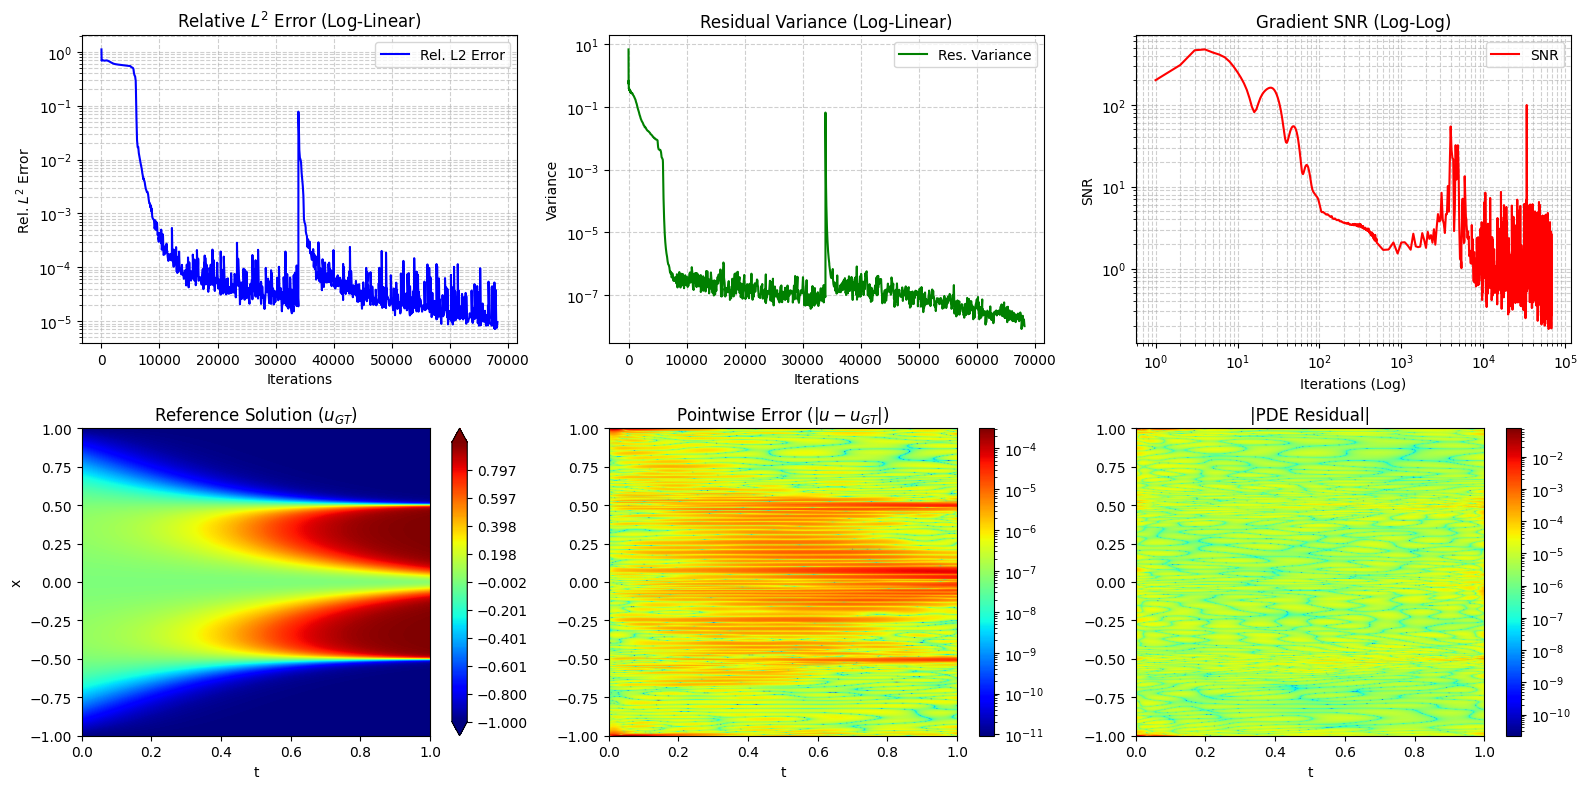

Minimum achieved RL2 error: 7.14365395523406e-06


In [6]:
# ## Cell 19: Final Visualization & Error Reporting
T, X = np.meshgrid(t0, x0)
# Ground Truth (already float64 due to T, X)
t = T.flatten()[:,None]
x = X.flatten()[:,None]
u_gt = Exact0.flatten()[:,None]
it=-1
print('Solution:')
u = apply_fn(current_params_for_eval, t, x)
error_best=relative_l2(u, u_gt)
print(f'Best mean residual models relative L2 error {error_best}')
# Create 2x3 layout
u = u.reshape(T.shape)
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
# --- ROW 1: METRICS ---
# 1. Relative L2 Error History (Top Left) -> Log Y only
ax_l2 = axes[0, 0]
ax_l2.plot(all_its, all_errors, label='Rel. L2 Error', color='blue')
ax_l2.set_yscale('log')
# X axis remains linear
ax_l2.set_title('Relative $L^2$ Error (Log-Linear)')
ax_l2.set_xlabel('Iterations')
ax_l2.set_ylabel('Rel. $L^2$ Error')
ax_l2.grid(True, which="both", ls="--", alpha=0.6)
ax_l2.legend()
# 2. Variance of Residuals History (Top Middle) -> Log Y only
ax_var = axes[0, 1]
ax_var.plot(all_its, all_var_res, label='Res. Variance', color='green')
ax_var.set_yscale('log')
# X axis remains linear
ax_var.set_title('Residual Variance (Log-Linear)')
ax_var.set_xlabel('Iterations')
ax_var.set_ylabel('Variance')
ax_var.grid(True, which="both", ls="--", alpha=0.6)
ax_var.legend()

# 3. SNR History (Top Right) -> Log X and Log Y
ax_snr = axes[0, 2]
ax_snr.plot(all_its, all_SNR, label='SNR', color='red')
ax_snr.set_xscale('log')
ax_snr.set_yscale('log')
ax_snr.set_title('Gradient SNR (Log-Log)')
ax_snr.set_xlabel('Iterations (Log)')
ax_snr.set_ylabel('SNR')
ax_snr.grid(True, which="both", ls="--", alpha=0.6)
ax_snr.legend()
# --- ROW 2: SPATIAL FIELDS ---
# Prepare shared levels for solution (Prediction/Truth) if needed, 
# though we are only plotting Truth here.
global_vmin = np.min([u, Exact0])
global_vmax = np.max([u, Exact0])
shared_levels = np.linspace(global_vmin, global_vmax, 500)
# 4. Reference Solution (Bottom Left)
ax_ref = axes[1, 0]
contour_ref = ax_ref.contourf(T, X, Exact0, cmap='jet', levels=shared_levels, extend='both')
fig.colorbar(contour_ref, ax=ax_ref)
ax_ref.set_xlabel('t')
ax_ref.set_ylabel('x')
ax_ref.set_title('Reference Solution ($u_{GT}$)')
# 5. Pointwise Error (Bottom Middle)
ax_err = axes[1, 1]
error_data = np.abs(Exact0 - u)
# Use LogNorm to visualize error orders of magnitude
err_log_norm = colors.LogNorm(vmin=max(1e-16, error_data.min()), vmax=max(1e-16, error_data.max()))
mesh_err = ax_err.pcolormesh(T, X, error_data, cmap='jet', norm=err_log_norm, shading='gouraud')
fig.colorbar(mesh_err, ax=ax_err)
ax_err.set_xlabel('t')
ax_err.set_title('Pointwise Error ($|u - u_{GT}|$)')
# 6. PDE Residual Map (Bottom Right)
ax_res = axes[1, 2]
print("Calculating PDE residuals for plotting...")
res = PDE_residuals(current_params_for_eval, t, x, apply_fn, 0.0001) 
res_grid = jnp.abs(res.reshape(T.shape))
print(f"Residuals calculated. Min: {res_grid.min()}, Max: {res_grid.max()}")
res_log_norm = colors.LogNorm(vmin=max(1e-16, res_grid.min()), vmax=max(1e-16, res_grid.max()))
mesh_res = ax_res.pcolormesh(T, X, res_grid, cmap='jet', norm=res_log_norm, shading='gouraud')
fig.colorbar(mesh_res, ax=ax_res)
ax_res.set_xlabel('t')
ax_res.set_title('|PDE Residual|')
plt.tight_layout()
plt.savefig(f'summary_metrics_fields_{METHOD}.png', dpi=150)
plt.show()
print('Minimum achieved RL2 error:', np.nanmin(all_errors))

In [7]:
# ## Cell 20: Save Experiment Results to .npz File
print("Saving prediction data to .npz file...")
# Dynamic filename with method suffix
save_filename = f'results_{METHOD}.npz'
np.savez(save_filename,
         # 1. Geometry & Solution
         T=T,
         X=X,
         u=u,                   # Final reshaped prediction
         u_exact=Exact0,        # Ground truth
         
         # 2. Spatial Residual Field
         residual_field=res_grid,

         # 3. Iteration & Metric History
         all_its=np.array(all_its),
         loss_history=np.array(all_loss),
         snr_history=np.array(all_SNR),
         
         # 4. Error Metrics History
         error_history=np.array(all_errors),       # Relative L2 Error
         Linf_error_history=np.array(all_L_infty), # Absolute L_inf Error of solution
         L2_error_history=np.array(all_L_2),       # Absolute L2 Error of solution
         
         # 5. Residual Metrics History
         var_history=np.array(all_var_res),        # Variance of PDE residuals
         linf_history=np.array(all_linf_res)       # Max Norm of PDE residuals
)

print(f"Data saved successfully to {save_filename}")
print(f"Saved keys: T, X, u, u_exact, residual_field, all_its, loss_history, snr_history, error_history, Linf_error_history, var_history, linf_history")

Saving prediction data to .npz file...
Data saved successfully to results_linear.npz
Saved keys: T, X, u, u_exact, residual_field, all_its, loss_history, snr_history, error_history, Linf_error_history, var_history, linf_history


: 